In [1]:
import torch
from torch import autograd as agd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, utils
import torchvision
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
import scipy as sp

In [2]:
#some global paraeters
in_dim = 2
nn_dim = 512 #const. throughout
batchSz = 400
n_epoch = 100
n_posBatch = 40
n_negBatch = 40
scale = 2

In [3]:
class GaussNet(nn.Module):
    
    def __init__(self):
        super(GaussNet, self).__init__()
        self.L1 = nn.Linear(in_dim, nn_dim)
        self.L2 = nn.Linear(nn_dim, nn_dim)
        self.Ou = nn.Linear(nn_dim,2)
    def forward(self, x):
        x = F.relu(self.L1(x))
        x = F.relu(self.L2(x))
        #x = F.relu(self.Ou(x))
        x = F.softmax(self.Ou(x))
        return x
    def name(self):
        return 'GaussNet'

In [4]:
#for dataset creation
class GMMsampler:
    
    def __init__( self, n_samples, n_components=1, weights=[1], mu=[np.array([0,0])], sig=[np.array([[1,0],[0,1]])]):
        self.n_components = n_components
        self.n_samples = n_samples
        self.weights = weights
        self.mu = mu
        self.sig = sig
        self.dim = mu[0].size
        self.data = np.empty([n_samples, self.dim])
        self.datacid = dict()
        
    def check_musig(self):
        shmu = self.mu[0].shape
        shsig = self.sig[0].shape
        if(not(all(m.shape==shmu for m in mu))):
            print('all mean vectors must be of same dimension')
        if(not(all(s.shape==shmu for s in sig))):
            print('all covariance matrix must be of same dimension')
    
    def gen_sample(self):
        for i in range(self.n_components):
            self.datacid[i] = []
        for i in range(self.n_samples):
            idx = np.random.choice(np.arange(0,self.n_components), p=(self.weights)/np.sum(self.weights))
            mu_,sig_ = self.mu[idx], self.sig[idx]
            self.data[i,:] = np.random.multivariate_normal(mu_, sig_)
            self.datacid[idx].append(self.data[i,:])
        for idx in range(self.n_components):
            self.datacid[idx] = np.array(self.datacid[idx]).reshape(-1,2)

m1 = np.array([-1, 0])
m2 = np.array([1, 0])
m3 = np.array([0, 1])
m4 = np.array([0, -1])
m5 = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
m6 = np.array([1/np.sqrt(2), -1/np.sqrt(2)])
m7 = np.array([-1/np.sqrt(2), 1/np.sqrt(2)])
m8 = np.array([-1/np.sqrt(2), -1/np.sqrt(2)])

sig1 = np.eye(2)*0.1414
sig2 = np.eye(2)*0.1414
sig3 = np.eye(2)*0.1414
sig4 = np.eye(2)*0.1414
sig5 = np.eye(2)*0.1414
sig6 = np.eye(2)*0.1414
sig7 = np.eye(2)*0.1414
sig8 = np.eye(2)*0.1414

In [5]:
#training data generator
def traindata_gen():
    g = GMMsampler(batchSz, n_components=8, weights=[1, 1, 1, 1, 1, 1, 1, 1],
                  mu=[m1,m2,m3,m4,m5,m6,m7,m8], sig=[sig1,sig2,sig3,sig4,sig5,sig6,sig7,sig8])
    while(True):
        g.gen_sample()
        yield g.data

In [6]:
d = traindata_gen()

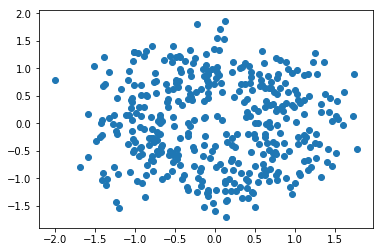

In [7]:
d_ = next(d)
plt.scatter(d_[:,0], d_[:,1])
plt.show()

In [8]:
#first just trying to train on a single gaussian
def traindata_gen1():
    g = GMMsampler(batchSz, n_components=1, weights=[1],
                  mu=[m1], sig=[sig1])
    while(True):
        g.gen_sample()
        yield g.data
d1 = traindata_gen1()

In [9]:
def traindata_genrand():
    while(True):
        g = GMMsampler(batchSz, n_components=1, weights=[1],
                      mu=[scale+np.random.randn(2)], sig=[np.random.randn()*np.eye(2)*scale])
        g.gen_sample()
        yield g.data

d1bar = traindata_gen1()

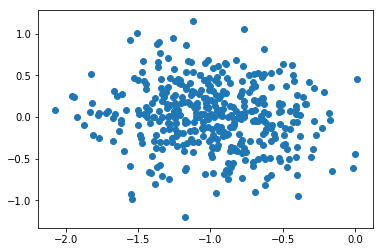

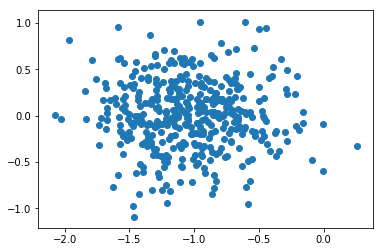

In [15]:
#the sample positive and negetive data points
plt.figure()
plt.scatter(next(d1)[:,0], next(d1)[:,1])
plt.show()

plt.figure()
plt.scatter(next(d1bar)[:,0], next(d1bar)[:,1])
plt.show()

In [11]:
#trying to train
model = GaussNet().cuda()
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.05)

In [12]:
#need to generate both positive and negetive datapoints to train the network
def gettraindata():
    traindata = []
    for i in range(n_posBatch):
        traindata.append((next(d1),np.array([1])))
    for i in range(n_negBatch):
        traindata.append((next(d1bar),np.array([0])))
    np.random.shuffle(traindata)
    return traindata

def gettestdata():
    testdata = []
    for i in range(1):
        traindata.append((next(d1),np.array([1])))
    for i in range(1):
        traindata.append((next(d1bar),np.array([0])))
    np.random.shuffle(testdata)
    return testdata

In [13]:
def plot_loss(losstrack):
    plt.figure()
    plt.plot(losstrack)
    plt.ylabel('loss value')
    plt.xlabel('iterations over various epoch')
    plt.show()

==>>> epoch: 0, batch: 0, train loss: 0.68796674
==>>> epoch: 0, batch: 5, train loss: 0.68341378
==>>> epoch: 0, batch: 10, train loss: 0.68187270
==>>> epoch: 0, batch: 15, train loss: 0.68369117
==>>> epoch: 0, batch: 20, train loss: 0.69754606
==>>> epoch: 0, batch: 25, train loss: 0.68902943
==>>> epoch: 0, batch: 30, train loss: 0.69042039
==>>> epoch: 0, batch: 35, train loss: 0.69405987
==>>> epoch: 0, batch: 40, train loss: 0.70018596
==>>> epoch: 0, batch: 45, train loss: 0.69832109
==>>> epoch: 0, batch: 50, train loss: 0.68632981
==>>> epoch: 0, batch: 55, train loss: 0.70802970
==>>> epoch: 0, batch: 60, train loss: 0.70624225
==>>> epoch: 0, batch: 65, train loss: 0.70429964
==>>> epoch: 0, batch: 70, train loss: 0.69567738
==>>> epoch: 0, batch: 75, train loss: 0.69717655
==>>> epoch: 2, batch: 0, train loss: 0.69580483
==>>> epoch: 2, batch: 5, train loss: 0.69090984
==>>> epoch: 2, batch: 10, train loss: 0.69800681
==>>> epoch: 2, batch: 15, train loss: 0.69094539
==>>

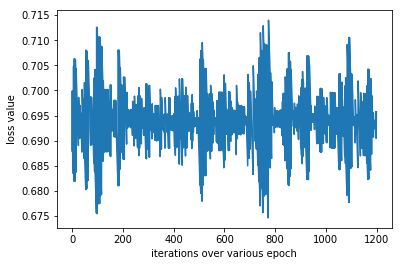

In [14]:
model.double()
n_epoch = 15
losstrack = []
for eph in range(n_epoch):
    traindata = gettraindata()
    for i in range(n_posBatch+n_negBatch):
        optimizer.zero_grad()
        X,label = traindata[i][0], traindata[i][1]
        X = torch.from_numpy(X)
        X = agd.Variable(X.cuda())
        lbl = [label[0] for i in range(batchSz)]
        lbl = np.array(lbl)
        lbl = torch.LongTensor(lbl)
        lbl = agd.Variable(lbl.cuda())
        outp = model(X)
        loss = F.cross_entropy(outp, lbl)
        loss.backward()
        optimizer.step()
        losstrack.append(loss.data[0])
        if i%5 == 0 and eph%2 == 0:
            print('==>>> epoch: {}, batch: {}, train loss: {:.8f}'.format(eph, i, loss.data[0]))

plot_loss(losstrack)       

In [16]:
#manually testing on positive and negetive points
tx=next(d1)
tx=torch.from_numpy(tx)
tx = agd.Variable(tx.cuda())
#print(tx)
tou = model(tx)
tou

Variable containing:
 0.5039  0.4961
 0.4987  0.5013
 0.5017  0.4983
 0.4987  0.5013
 0.5038  0.4962
 0.4797  0.5203
 0.5027  0.4973
 0.5041  0.4959
 0.4986  0.5014
 0.5033  0.4967
 0.4977  0.5023
 0.5009  0.4991
 0.5006  0.4994
 0.4931  0.5069
 0.4934  0.5066
 0.4885  0.5115
 0.4842  0.5158
 0.5035  0.4965
 0.4904  0.5096
 0.4928  0.5072
 0.5011  0.4989
 0.5032  0.4968
 0.5115  0.4885
 0.5005  0.4995
 0.4952  0.5048
 0.4915  0.5085
 0.4953  0.5047
 0.5160  0.4840
 0.5020  0.4980
 0.4808  0.5192
 0.5048  0.4952
 0.4980  0.5020
 0.4988  0.5012
 0.5175  0.4825
 0.4933  0.5067
 0.5089  0.4911
 0.5028  0.4972
 0.4875  0.5125
 0.5011  0.4989
 0.4796  0.5204
 0.5211  0.4789
 0.4864  0.5136
 0.5039  0.4961
 0.5085  0.4915
 0.5057  0.4943
 0.5110  0.4890
 0.5120  0.4880
 0.5043  0.4957
 0.4966  0.5034
 0.5014  0.4986
 0.5075  0.4925
 0.4997  0.5003
 0.4758  0.5242
 0.5097  0.4903
 0.5077  0.4923
 0.4936  0.5064
 0.4952  0.5048
 0.4716  0.5284
 0.4961  0.5039
 0.5031  0.4969
 0.5051  0.4949
 0.

In [17]:
txbar=next(d1bar)
txbar=torch.from_numpy(txbar)
txbar = agd.Variable(txbar.cuda())
#print(tx)
toubar = model(txbar)
toubar

Variable containing:
 0.5066  0.4934
 0.5099  0.4901
 0.5077  0.4923
 0.5023  0.4977
 0.5060  0.4940
 0.5188  0.4812
 0.5229  0.4771
 0.5087  0.4913
 0.5107  0.4893
 0.5141  0.4859
 0.4956  0.5044
 0.5172  0.4828
 0.4895  0.5105
 0.5103  0.4897
 0.5024  0.4976
 0.5161  0.4839
 0.5017  0.4983
 0.4988  0.5012
 0.4818  0.5182
 0.4986  0.5014
 0.4998  0.5002
 0.5003  0.4997
 0.5089  0.4911
 0.5203  0.4797
 0.5100  0.4900
 0.5094  0.4906
 0.4871  0.5129
 0.4973  0.5027
 0.5026  0.4974
 0.5060  0.4940
 0.5072  0.4928
 0.5171  0.4829
 0.5079  0.4921
 0.4952  0.5048
 0.4924  0.5076
 0.5010  0.4990
 0.4978  0.5022
 0.4955  0.5045
 0.4959  0.5041
 0.5072  0.4928
 0.4980  0.5020
 0.5103  0.4897
 0.5083  0.4917
 0.5140  0.4860
 0.5063  0.4937
 0.4978  0.5022
 0.5160  0.4840
 0.5017  0.4983
 0.5045  0.4955
 0.4742  0.5258
 0.5164  0.4836
 0.5131  0.4869
 0.5017  0.4983
 0.5111  0.4889
 0.5110  0.4890
 0.5200  0.4800
 0.5011  0.4989
 0.5102  0.4898
 0.5110  0.4890
 0.5040  0.4960
 0.4955  0.5045
 0.

In [20]:
model

GaussNet (
  (L1): Linear (2 -> 512)
  (L2): Linear (512 -> 512)
  (Ou): Linear (512 -> 2)
)